In [1]:
using CRCBS
using SpecialFunctions
using Distributions

┌ Info: Recompiling stale cache file /home/peltzer/.julia/compiled/v1.0/CRCBS/26Ksw.ji for CRCBS [edef75b8-3ac4-11e9-0392-bf149c536ee3]
└ @ Base loading.jl:1190
┌ Warning: Package CRCBS does not have JLD in its dependencies:
│ - If you have CRCBS checked out for development and have
│   added JLD as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with CRCBS
└ Loading JLD into CRCBS from project dependency, future warnings for CRCBS are suppressed.
┌ Warning: Replacing docs for `CRCBS.get_dist_matrix :: Tuple{LightGraphs.AbstractGraph}` in module `CRCBS`
└ @ Base.Docs docs/Docs.jl:223
┌ Warning: Replacing docs for `CRCBS.pad_matrix :: Union{Tuple{T}, Tuple{Array{T,2},Tuple{Int64,Int64},T}} where T` in module `CRCBS`
└ @ Base.Docs docs/Docs.jl:223


### Monte Carlo

In [2]:
using Distributions
function count_conflicts(n1,t1,n2,t2,nn,lambda,num_particles)
    EA1 = rand(Gamma(n1,lambda),num_particles)
    EA2 = rand(Gamma(n2,lambda),num_particles)
    ed1 = rand(Gamma(nn,lambda),num_particles)
    ed2 = rand(Gamma(nn,lambda),num_particles)
    
    r1_arrivals = t1 .+ EA1
    r1_departures = r1_arrivals + ed1
    r2_arrivals = t2 .+ EA2
    r2_departures = r2_arrivals + ed2
    
    num_conflicts =length(findall(((r2_departures-r1_arrivals).>0) .& ((r1_departures-r2_arrivals).>0)   ))
    
    return num_conflicts/num_particles
end

count_conflicts (generic function with 1 method)

### Double Integration

In [3]:
using HCubature
function get_collision_probability_node_double(n1,t1,n2,t2,nn,lambda;bound_radius=50)

    function hy(x)
        y = x[1]
        function ht(x)
            t = x[1]
            density = (1-cdf(Gamma(nn,lambda),abs(t2-t1-y))) * pdf(Gamma(n1,lambda), t) * pdf(Gamma(n2,lambda),t-y)
            return density
        end
        
        o = [0.0]
        p = 200 .* [1.0]

        C, err = hcubature(ht,o,p,maxevals=10^8)
        
        return C
        
    end

    a = [-100.0;0.0]
    b = [0.0,100.0]
    m = [0.0;0.0]
    n = [100.0,100.0]
    
    #bound = max(t1+n1,t2+n2)*lambda + 30.0
    bound = bound_radius
    
    o = bound.*[-1.0]
    p = bound.*[1.0]

    C, err = hcubature(hy,o,p,maxevals=10^8)

    return C, err
end

get_collision_probability_node_double (generic function with 1 method)

In [4]:
function density_double_Int(n1,t1,n2,t2,nn,lambda,y;bound_radius=50)
    function h(x)
        t = x[1]
        density = (1-cdf(Gamma(nn,lambda),abs(t2-t1-y))) * pdf(Gamma(n1,lambda), t) * pdf(Gamma(n2,lambda),t-y)
        return density
    end
    
    o = [0.0]
    p = 200 .* [1.0]
    
    C, err = hcubature(h,o,p,maxevals=10^8)
    
    return C
end

density_double_Int (generic function with 1 method)

### Whittaker

In [5]:
a = Hypergeometric1F1(5,2,100-1000im,50)

7.002864442038907e50 + 8.97377576745836e50im

In [6]:
function hplus(nn,c1,lambda,alpha,beta,phi,y)
    density = (1-cdf(Gamma(nn,lambda),abs(t1-t2-y))) * c1 * 1.0/(y^phi) * WhittakerM_cont(alpha,beta,2*y/lambda)
    return density
end

function hminus(nn,c2,lambda,alpha,beta,phi,y)
    density = (1-cdf(Gamma(nn,lambda),abs(t1-t2-y))) * c2 * 1.0/((-y)^phi) * WhittakerM_cont(-alpha,beta,-2*y/lambda)
    return density
end

hminus (generic function with 1 method)

### Tests

In [18]:
n1=3
n2=2
t1=3.0
t2=5.0
nn=3
lambda=1.0

1.0

In [19]:
alpha = 0.5*(n1-n2)
beta = 0.5*(1-n1-n2)
c1 = 1.0/(gamma(n1)*(2.0/lambda)^((n1+n2)/2.0))
c2 = 1.0/(gamma(n2)*(2.0/lambda)^((n1+n2)/2.0))
phi = 0.5*(n1+n2)

1.0/(100^phi)

1.0e-5

In [20]:
get_collision_probability_node_double(n1,t1,n2,t2,nn,lambda;bound_radius=50)

(0.6973289374170533, 9.757297696279614e-9)

In [21]:
count_conflicts(n1,t1,n2,t2,nn,lambda,10000)

0.698

In [22]:
using Plots

In [23]:
density_double_Int(n1,t1,n2,t2,nn,lambda,0.01;bound_radius=50)

0.12780680205077402

In [24]:
hplus(nn,c1,lambda,alpha,beta,phi,0.01)

2.1122944573129653e6

In [25]:
c1

0.08838834764831843

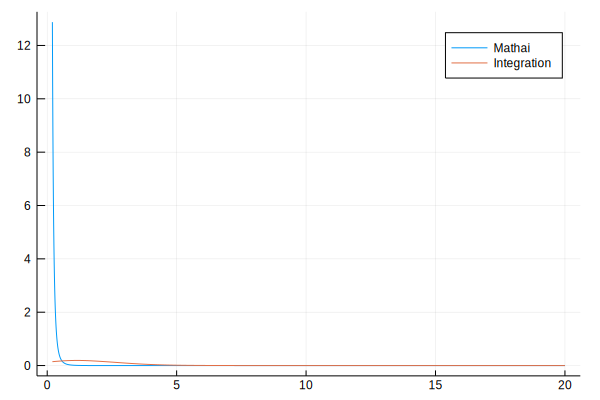

In [29]:
listy = collect(range(0.2,stop=20.0,step=0.01))
listd = [hplus(nn,c1,lambda,alpha,beta,phi,y) for y in listy]
listdd = [density_double_Int(n1,t1,n2,t2,nn,lambda,y) for y in listy]
listmy = collect(range(-20,stop=-0.2,step=0.01))
listmd = [hminus(nn,c2,lambda,alpha,beta,phi,y) for y in listmy]
listmdd = [density_double_Int(n1,t1,n2,t2,nn,lambda,y) for y in listmy]
plot(listy,listd,label="Mathai")
plot!(listy,listdd,label="Integration")

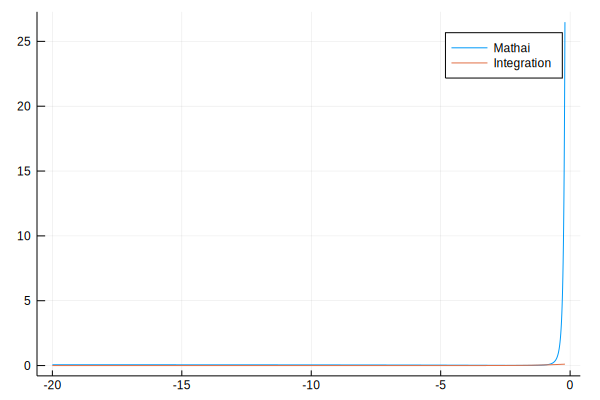

In [30]:
plot(listmy,listmd,label="Mathai")
plot!(listmy,listmdd,label="Integration")

In [ ]:
y=0.01
density = (1-cdf(Gamma(nn,lambda),abs(t1-t2-y))) * c1 * 1.0/(y^phi) * WhittakerM(alpha,beta,2*y/lambda)

In [86]:
WhittakerM(1,4,5)

1093.1585790702625

In [87]:
WhittakerW(1,2,3)

-44297.63445690515

In [ ]:
conflict_probability_node_w(n1,t1,n2,t2,nn,lambda)

In [ ]:
a=-2.0
b=-3.0
t=2500.0004999999996
N=50

h = 2*pi/N

c1 = 0.5017
c2 = 0.6407
c3 = 0.6122
c4 = 0.2645im

k = collect(1:N)
theta   = -pi .+ (k .+ 0.5)*h
z   = N/t*(c1*theta ./ Float64[tan(c2*thetai) for thetai in theta] .- c3 .+ c4*theta)
dz  = N/t*(-c1*c2*theta ./ Float64[sin(c2*thetai) for thetai in theta].^2 .+ c1./ Float64[tan(c2*thetai) for thetai in theta] .+ c4)

F = z .^(-b).*(1 .+ 1.0 ./z).^(a-b)

In [ ]:
evalint = sum([exp(zi*t) for zi in z] .* F .* dz)

In [ ]:
using Distributions
using SpecialFunctions

In [ ]:
inverse = try (t)^(1-b)
catch 
    (conj(t)/(norm(t))^2)^(b-1)
end

In [ ]:
val = gamma(b)*inverse*exp(t)*h/(2im*pi).*evalint